# Design and test a Notch

reference  
- code : https://www.geeksforgeeks.org/design-an-iir-notch-filter-to-denoise-signal-using-python/ 
- notch : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html

In [1]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
plt.rcParams["figure.figsize"] = 10,5
plt.rcParams["font.size"] = 16
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

In [2]:
plt.rcParams.update(plt.rcParamsDefault)

## 1. Generate a test signal
 
* A simple test signal $\boldsymbol{y} = \{ y_i \}$ is generated with a fixed sampling frequency using the function:

$$y(t) = m_0 \sin(2\pi f_0 t) + m_1 \sin(2\pi f_1 t)$$

* The power spectrum is plotted as the magnitude of the discrete fourier transform (DFT): $|\hat{\boldsymbol{y}}|$

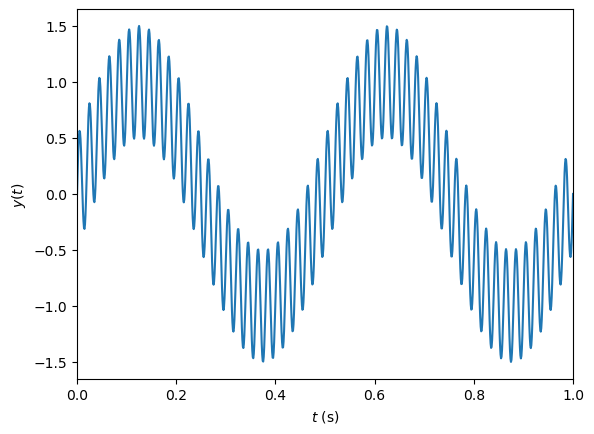

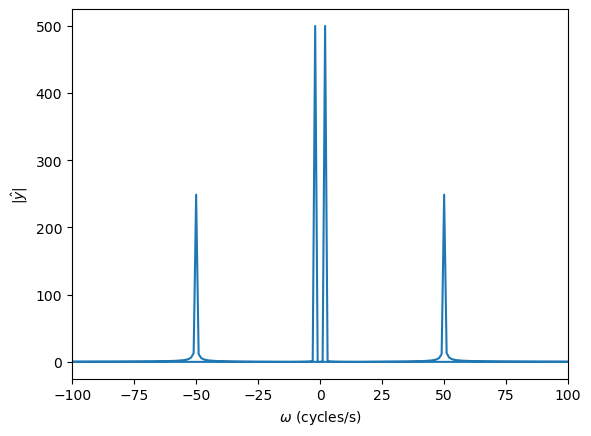

In [3]:
# Generate a signal
samplingFreq = 1000; # sampled at 1 kHz = 1000 samples / second
tlims = [0,1]        # in seconds
signalFreq = [2,50]; # Cycles / second
signalMag = [1,0.5]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
plt.figure()
plt.plot(t,y);
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");
plt.xlim([min(t),max(t)]);

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");
plt.show()

## 2. Discrete transfer function (notch)



In [5]:
# Create/view notch filter
samp_freq = 1000  # Sample frequency (Hz)
notch_freq = 50.0  # Frequency to be removed from signal (Hz)
quality_factor = 20.0  # Quality factor

In [7]:
#Design a notch filter using signal.iirnotch
b, a = signal.iirnotch(notch_freq, quality_factor, samp_freq)
 
# Compute magnitude response of the designed filter
freq, h = signal.freqz(b, a, fs=2*np.pi)

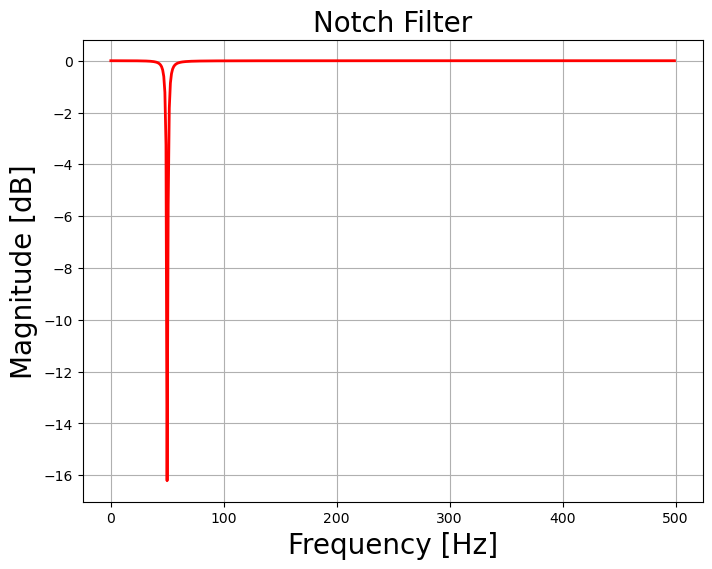

In [8]:
fig = plt.figure(figsize=(8, 6))
 
# Plot magnitude response of the filter
plt.plot(freq*samp_freq/(2*np.pi), 20 * np.log10(abs(h)),
         'r', label='Bandpass filter', linewidth='2')
 
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Magnitude [dB]', fontsize=20)
plt.title('Notch Filter', fontsize=20)
plt.grid()
plt.show()

In [9]:
b

array([ 0.99220706, -1.88728999,  0.99220706])

In [10]:
a

array([ 1.        , -1.88728999,  0.98441413])

## 4. Filter coefficients

We want to find the filter coefficients for the discrete update:
$$y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$$

The coefficients can be taken directly from the discrete transfer function of the filter in the form:
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots}{1 - a_1 z^{-1} - a_2 z^{-2} + \ldots}$$

(This is a result of taking the Z-transform which is not shown here)

Compare this to a transfer function with coefficients
<code>
num = [b_0, b_1, b_2]
den = [1, a_1, a_2]
</code>
is 
$$H(z) = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}$$
which is equivalent to
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$$
So you can take the coefficients in the same order that they are defined in the numerator and denominator of the transfer function object. The only difference is that the **coefficients in the denominator need a negative sign**.

* To filter the signal, apply the filter using the discrete update
* The filtered signal and filtered signal power spectrum are plotted alongside the unfiltered signal

Filter coefficients b_i: [ 0.99220706 -1.88728999  0.99220706]
Filter coefficients a_i: [-1.88728999  0.98441413]


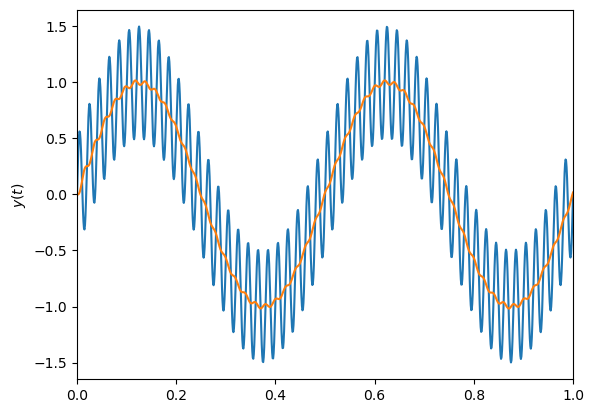

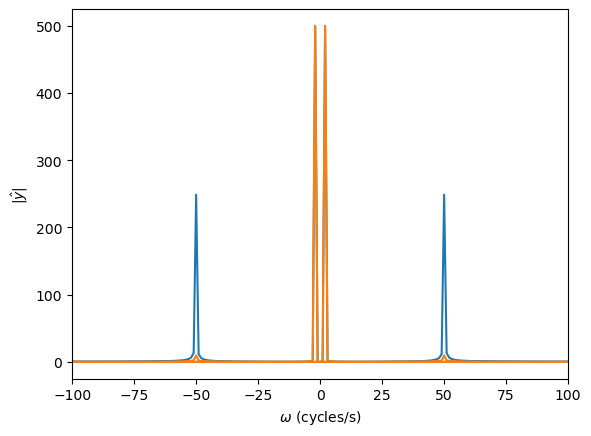

In [17]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

b = b
a = -a

# Filter the signal
yfilt = np.zeros(len(y))
for i in range(3,len(y)):
    yfilt[i] = a[1]*yfilt[i-1]+a[2]*yfilt[i-2] + b[0]*y[i] + b[1]*y[i-1] + b[2]*y[i-2]
    
# Plot the signal
plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)]);
plt.show()

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.plot(fcycles,np.absolute(yfilthat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");
plt.show()